In [ ]:
# Mount the Google Drive to access files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
# from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Input
from tensorflow.keras.layers import LeakyReLU, BatchNormalization
from tensorflow.keras.layers import concatenate
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import to_categorical, plot_model

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os
import sys
import time

from IPython.display import Image, display

In [ ]:
main_path = "/content/drive/MyDrive/DLProject/"
sys.path.append(main_path)

In [ ]:
import mmwchanmod 

In [ ]:
# Load the data
fn = 'factory_warehouse.p'
with open(main_path+fn, 'rb') as fp:
    config,train_data,test_data = pickle.load(fp)

In [ ]:
# print(f"The train set has size of {train_data.shape}")
# print(f"The test set has size of {test_data.shape}")
if not os.path.isdir('./generated_paths'):
  os.mkdir('./generated_paths')

print(train_data.keys())

dict_keys(['dvec', 'link_state', 'los_pl', 'los_ang', 'los_dly', 'nlos_pl', 'nlos_ang', 'nlos_dly'])


In [ ]:
num_link = train_data['dvec'].shape[0]
train_data['dist'] = np.zeros(num_link)
train_data['pl_omni'] = np.zeros(num_link)
los_index = []
nlos_index = []
outage_index = []
for link in range(num_link):
  if train_data['link_state'][link] == 1:
    los_index.append(link)
  elif train_data['link_state'][link] == 2:
    nlos_index.append(link)
  elif train_data['link_state'][link] == 0:
    outage_index.append(link)
  else:
    print(f'Unexpected link state at {link}')
  dvec = train_data['dvec'][link]
  train_data['dist'][link] = np.sqrt(np.dot(dvec,dvec))
  los_pl = train_data['los_pl'][link]
  nlos_pl = train_data['nlos_pl'][link]
  nlos_pr_lin = np.sum(10**((0-nlos_pl)/10))
  pr_lin = 10**((0-los_pl)/10) + nlos_pr_lin
  train_data['pl_omni'][link] = 0-10*np.log10(pr_lin)

In [ ]:
from scipy.constants import c, pi
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse
fc = 28e9
lamb = c/fc
d0 = 1
fspl0 = 20*np.log10(4*pi*d0*fc/c)
num_paths = 20

In [ ]:
def compute_ple(dist_vals, pl_vals, fc, d0):
  """Compute the PLE and SF based on the input pathloss value"""
  lamb = c/fc
  fspl0 = 20*np.log10(4*pi*d0*fc/c)
  dist = 10*np.log10(dist_vals).reshape((-1,1))
  pl = pl_vals.reshape((-1,1)) - fspl0
  ple,res_sum,_,_ = np.linalg.lstsq(dist,pl,rcond=None)
  ple = ple.item()
  sf_std = np.sqrt(res_sum/dist.shape[0]).item()
  return ple, sf_std

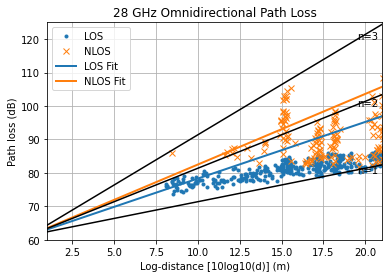

LOS locations - PLE:1.69, SF:1.65
NLOS locations - PLE:2.11, SF:5.32


In [ ]:

ple_los, sf_los_std = compute_ple(train_data['dist'][los_index],
                                  train_data['pl_omni'][los_index], fc, d0)

ple_nlos, sf_nlos_std = compute_ple(train_data['dist'][nlos_index],
                                  train_data['pl_omni'][nlos_index], fc, d0)

plt.plot(train_data['dist'][los_index],train_data['pl_omni'][los_index],'.',c='C0')
plt.plot(train_data['dist'][nlos_index],train_data['pl_omni'][nlos_index],'x',c='C1')
plt.xlim([1,21])
plt.ylim([60,125])

plt.plot(np.linspace(0,21,num=100),fspl0+ple_los*np.linspace(0,21,num=100),
         c='C0',lw=2)
plt.plot(np.linspace(0,21,num=100),fspl0+ple_nlos*np.linspace(0,21,num=100),
         c='C1',lw=2)
plt.legend(['LOS','NLOS','LOS Fit','NLOS Fit'])
plt.plot(np.linspace(0,21,num=100),fspl0+2*np.linspace(0,21,num=100),'k')
plt.plot(np.linspace(0,21,num=100),fspl0+1*np.linspace(0,21,num=100),'k')
plt.plot(np.linspace(0,21,num=100),fspl0+3*np.linspace(0,21,num=100),'k')
plt.annotate('n=1',(19.5,80))
plt.annotate('n=2',(19.5,100))
plt.annotate('n=3',(19.5,120))
plt.title('28 GHz Omnidirectional Path Loss')
plt.xlabel('Log-distance [10log10(d)] (m)')
plt.ylabel('Path loss (dB)')
plt.grid(True)
plt.show()

print(f'LOS locations - PLE:{ple_los:.2f}, SF:{sf_los_std:.2f}')
print(f'NLOS locations - PLE:{ple_nlos:.2f}, SF:{sf_nlos_std:.2f}')

In [ ]:
from sklearn.preprocessing import MinMaxScaler

In [ ]:
test_path = os.path.join("/content/generated_paths/train_data0.csv")
# np.savetxt("./generated_paths/train_data0.csv", train_data, delimiter=",")
# ahh = pd.DataFrame.from_dict(train_data)
ddd = pd.DataFrame(train_data['nlos_pl']).to_csv(test_path)

In [ ]:
def data_scaler(data_in, range):
  scaler = MinMaxScaler(feature_range=range)
  data_out = scaler.fit_transform(data_in)
  return data_out, scaler

In [ ]:
def compute_los_dir(dvec):
  x = dvec[:,0]
  y = dvec[:,1]
  z = dvec[:,2]
  aod = np.arctan(y/x)*180/pi
  zod = np.arctan(np.linalg.norm(dvec[:,0:2])/z)*180/pi
  zoa = 180 - zod
  aoa = np.zeros_like(aod)
  for i in range(dvec.shape[0]):
    if aod[i] >= 0:
      aoa[i] = aod[i] - 180
    else:
      aoa[i] = aod[i] + 180

  return (aoa, zoa, aod, zod)

In [ ]:
def dataset_scaler(dvec, nlos_info, num_paths):
  scaler_list = []

  aoa, zoa, aod, zod = compute_los_dir(dvec)

  nlos_info_scaled = np.zeros_like(nlos_info)
  # Data preprocessing
  # Power
  pl_arr = nlos_info[:,np.array(range(num_paths))*6]
  pl_scaled, pl_scaler = data_scaler(pl_arr.reshape((-1,1)),(0,1))
  nlos_info_scaled[:,np.array(range(num_paths))*6] = pl_scaled.reshape(-1,num_paths)
  scaler_list.append(pl_scaler)
  # Delay
  dly_arr = nlos_info[:,np.array(range(num_paths))*6+1]
  dly_scaled, dly_scaler = data_scaler(dly_arr.reshape((-1,1)),(0,1))
  nlos_info_scaled[:,np.array(range(num_paths))*6+1] = dly_scaled.reshape(-1,num_paths)
  scaler_list.append(dly_scaler)
  # AOA
  aoa_arr = nlos_info[:,np.array(range(num_paths))*6+2]
  # with respect to LOS direction
  aoa_arr_wl = (aoa_arr - aoa.reshape((-1,1))) % 360
  # ZOA
  zoa_arr = nlos_info[:,np.array(range(num_paths))*6+3]
  # with respect to LOS direction
  zoa_arr_wl = (zoa_arr - zoa.reshape((-1,1))) % 360
  # AOD
  aod_arr = nlos_info[:,np.array(range(num_paths))*6+4]
  # with respect to LOS direction
  aod_arr_wl = (aod_arr - aod.reshape((-1,1))) % 360
  # ZOD
  zod_arr = nlos_info[:,np.array(range(num_paths))*6+5]
  # with respect to LOS direction
  zod_arr_wl = (zod_arr - zod.reshape((-1,1))) % 360
  
  ang_arr_wl = np.concatenate((aoa_arr_wl,zoa_arr_wl,aod_arr_wl,zod_arr_wl),axis=1)
  ang_scaled, ang_scaler = data_scaler(ang_arr_wl.reshape((-1,1)),(0,1))
  ang_scaled = ang_scaled.reshape((-1,num_paths*4))
  ang_index = np.arange(4).reshape((1,-1)) + np.arange(20).reshape((-1,1))*6 + 2
  ang_index = ang_index.reshape((1,-1))[0]
  nlos_info_scaled[:,ang_index] = ang_scaled
  scaler_list.append(ang_scaler)

  # aoa_scaled, aoa_scaler = data_scaler(aoa_arr_wl.T,(0,1))
  # nlos_info_scaled[:,np.array(range(num_paths))*6+2] = aoa_scaled.T
  # scaler_list.append(aoa_scaler)

  # zoa_scaled, zoa_scaler = data_scaler(zoa_arr_wl.T,(0,1))
  # nlos_info_scaled[:,np.array(range(num_paths))*6+3] = zoa_scaled.T
  # scaler_list.append(zoa_scaler)

  # aod_scaled, aod_scaler = data_scaler(aod_arr_wl.T,(0,1))
  # nlos_info_scaled[:,np.array(range(num_paths))*6+4] = aod_scaled.T
  # scaler_list.append(aod_scaler)
  
  # zod_scaled, zod_scaler = data_scaler(zod_arr_wl.T,(0,1))
  # nlos_info_scaled[:,np.array(range(num_paths))*6+5] = zod_scaled.T
  # scaler_list.append(zod_scaler)

  return nlos_info_scaled, scaler_list

In [ ]:
def data_transform(dataset):
  num_links = dataset['link_state'].shape[0]
  num_paths = 20
  nlos_info = np.zeros((num_links, 6*num_paths))
  data_loader = np.zeros((num_links, 6*num_paths+4))
  for ipath in range(num_paths):
    nlos_info[:,ipath*6] = dataset['nlos_pl'][:,ipath]
    nlos_info[:,ipath*6+1] = dataset['nlos_dly'][:,ipath]
    nlos_info[:,ipath*6+2:ipath*6+6] = dataset['nlos_ang'][:,ipath,:]
  
  nlos_info, scaler_list = dataset_scaler(dataset['dvec'], nlos_info, num_paths)

  for ilk in range(num_links):
    dvec_this = dataset['dvec'][ilk,:]
    d_3D_this = np.linalg.norm(dvec_this)
    lkstate_this = dataset['link_state'][ilk]
    # print([d_3D_this, 10*np.log10(d_3D_this), dvec_this[ilk,2], lkstate_this])
    u = np.array([d_3D_this, 10*np.log10(d_3D_this), dvec_this[2], lkstate_this])
    x = nlos_info[ilk,:]
    data_loader[ilk,:] = np.concatenate((u,x))
  # print(nlos_info[:1,:])
  return data_loader, scaler_list

In [ ]:
# Order: d_3D, 10log10(d_3D), d_z, los/nlos, 6 parameters by 20 paths
train_samples,scaler_train = data_transform(train_data)
test_samples,scaler_test = data_transform(test_data)

In [ ]:
# next(iter(train_dataset))\
input_size = 2 # d_3D and d_z 
label_size = 3
BATCH_SIZE = 128

In [ ]:
link_train = train_samples[:,[0,2]]
link_test = test_samples[:,[0,2]]
label_train = train_samples[:,3]
label_test = test_samples[:,3]
num_labels = len(np.unique(label_train))
label_train = to_categorical(label_train)
label_test = to_categorical(label_test)

In [ ]:
# Train and test the link state net
def make_state_model():
  model = Sequential()
  model.add(Dense(32, input_dim=input_size))
  model.add(Activation('sigmoid'))
  model.add(Dense(64))
  model.add(Activation('sigmoid'))
  model.add(Dense(32))
  model.add(Activation('sigmoid'))
  model.add(Dense(label_size))
  model.add(Activation('softmax'))
  # model.summary()
  
  return model

In [ ]:
link_state_model = make_state_model()
link_state_model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
# train the network
link_state_model.fit(link_train, label_train, epochs=100, batch_size=BATCH_SIZE,
                     verbose=0)
_, acc = link_state_model.evaluate(link_test,
                        label_test,
                        batch_size=BATCH_SIZE,
                        verbose=0)
print("Test accuracy: %.1f%%" % (100.0 * acc))

Test accuracy: 61.6%


In [ ]:
def link_state_predict(model, data):
  num_links = data.shape[0]
  link_state_arr = np.zeros(num_links)
  for i in range(data.shape[0]):
    p_pred = model.predict(data[i,:].reshape((1,-1)))
    link_state_arr[i] = np.random.choice(3,p=p_pred[0])

  return link_state_arr

In [ ]:
# Creat tf dataset
train_dataset = tf.data.Dataset.from_tensor_slices(train_samples)
test_dataset = tf.data.Dataset.from_tensor_slices(test_samples)

BUFFERSIZE = train_samples.shape[0]
BATCH_SIZE = 64

train_dataset = train_dataset.shuffle(BUFFERSIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BUFFERSIZE)

In [ ]:
path_dim = 124
latent_dim = 20
num_classes = 3

In [ ]:
def build_generator(inputs, 
                    path_size,
                    labels, 
                    activation='sigmoid'):
  """Build a Generator Model of CGAN or ACGAN"""
  layer_filters = [32, 64, 128]

  inputs_label = [inputs, labels]
  x = concatenate(inputs_label, axis=1)
  

  for filters in layer_filters:
    x = Dense(filters)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = LeakyReLU(alpha=0.2)(x)

  x = Dense(path_size)(x)
  if activation is not None:
    x = Activation(activation)(x)
  generator = Model(inputs_label, x, name='generator')
  return generator

In [ ]:
def build_discriminator(inputs, 
                        num_labels, 
                        activation='sigmoid'):
  """Build a Discriminator Model"""
  x = inputs
  layer_filters = [128, 64, 32]
  for filters in layer_filters:
    x = Dense(filters)(x)
    x = BatchNormalization(momentum=0.8)(x)
    x = LeakyReLU(alpha=0.2)(x)
  
  outputs = Dense(1)(x)
  # print(f"OOOutputshape {outputs.shape}")
  if activation is not None:
    outputs = Activation(activation)(outputs)

  if num_labels:
    y = Dense(layer_filters[-1])(x)
    y = Dense(num_labels)(y)
    y = Activation('softmax',name='label')(y)
    outputs = [outputs, y]

  # print(f"input shape {inputs.shape}")
  # print(f"Output Shape {outputs[0]}")
  # print(f"Output Shape {outputs[1]}")
  return Model(inputs, outputs, name='discriminator')

In [ ]:
def train(models, data, params):
  """Train the discriminator and Adversarial networks"""
  generator, discriminator, adversarial = models
  x_train, y_train = data
  batch_size, latent_size, train_steps, num_labels, num_samples_generate, \
        model_name = params
  save_interval = 100
  noise_input = np.random.uniform(-1.0, 
                                  1.0, 
                                  size=[num_samples_generate, latent_size])
  noise_label = np.eye(num_labels)[np.arange(0,num_samples_generate) % num_labels]
  train_size = x_train.shape[0]
  # print(model_name,
  #       "Labels for generated images: ",
  #       np.argmax(noise_label, axis=1))
  
  for i in range(train_steps):
    rand_indexes = np.random.randint(0,
                                     train_size,
                                     size=batch_size)
    real_channs = x_train[rand_indexes]
    real_labels = y_train[rand_indexes]

    noise = np.random.uniform(-1.0, 1.0,
                              size=[batch_size, latent_size])
    
    fake_labels = np.eye(num_labels)[np.random.choice(num_labels,batch_size)]

    fake_channs = generator.predict([noise, fake_labels])
    x = np.concatenate((real_channs, fake_channs))
    labels = np.concatenate((real_labels, fake_labels))

    y = np.ones([2*batch_size, 1])
    y[batch_size:,:] = 0
    # print(x.shape)
    # print(y.shape)
    # print(labels.shape)
    metrics = discriminator.train_on_batch(x, [y,labels])
    fmt = "%d: [disc loss: %f, srcloss: %f," 
    fmt += "lblloss: %f, srcacc: %f, lblacc: %f]" 
    log = fmt % (i, metrics[0], metrics[1], \
            metrics[2], metrics[3], metrics[4])
    

    noise = np.random.uniform(-1.0, 1.0, size=[batch_size, latent_size])
    fake_labels = np.eye(num_labels)[np.random.choice(num_labels, batch_size)]
    y = np.ones([batch_size, 1])
    metrics = adversarial.train_on_batch([noise,fake_labels],[y,fake_labels])
    fmt = "%s [advr loss: %f, srcloss: %f,"
    fmt += "lblloss: %f, srcacc: %f, lblacc: %f]" 
    log = fmt % (log, metrics[0], metrics[1],\
            metrics[2], metrics[3], metrics[4])
    
    if (i+1) % save_interval == 0:
      print(f"It's time to check channels babe - Epoch {i+1}")
      print(log)

In [ ]:
x_train = train_samples[:,4:]
y_train = train_samples[:,3]
all_index = np.arange(y_train.shape[0])
good_index = np.setdiff1d(all_index,np.array(outage_index))
x_train = x_train[good_index,:]
y_train = y_train[good_index]

In [ ]:
# Convert labels to 0 and 1
y_train = -y_train+2
num_labels = len(np.unique(y_train))
y_train = to_categorical(y_train,num_classes=num_labels)

model_name = 'acgan_channmod'

latent_size = 20
path_size = 120

batch_size = 64
train_steps = 5000
num_samples_generate = 32
lr = 2e-4
decay = 1e-8
input_shape = (x_train.shape[1], )
label_shape = (num_labels,)

inputs = Input(shape=input_shape,
                name='discriminator_input')

discriminator = build_discriminator(inputs, num_labels=num_labels)
optimizer = RMSprop(lr=lr, decay=decay)
loss = ['binary_crossentropy', 'categorical_crossentropy']
discriminator.compile(loss=loss,
                      optimizer=optimizer,
                      metrics=['accuracy'])
# discriminator.summary()

input_shape = (latent_size, )
inputs = Input(shape=input_shape, name='z_input')
labels = Input(shape=label_shape, name='labels')
generator = build_generator(inputs, path_size, labels=labels)
# generator.summary()

optimizer = RMSprop(lr=lr*0.5, decay=decay*0.5)
discriminator.trainable = False
adversarial = Model([inputs, labels], 
                    discriminator(generator([inputs,labels])),
                    name=model_name)
adversarial.compile(loss=loss,
                    optimizer=optimizer,
                    metrics=['accuracy'])
# adversarial.summary()

models = (generator, discriminator, adversarial)
data = (x_train,y_train)
params = (batch_size, latent_size, train_steps, num_labels,\
          num_samples_generate, model_name)
train(models, data, params)

It's time to check channels babe - Epoch 100
99: [disc loss: 0.500223, srcloss: 0.135809,lblloss: 0.364414, srcacc: 0.984375, lblacc: 0.828125] [advr loss: 2.812528, srcloss: 2.714730,lblloss: 0.097798, srcacc: 0.000000, lblacc: 1.000000]
It's time to check channels babe - Epoch 200
199: [disc loss: 0.303150, srcloss: 0.092903,lblloss: 0.210247, srcacc: 0.984375, lblacc: 0.929688] [advr loss: 2.966614, srcloss: 2.914050,lblloss: 0.052565, srcacc: 0.000000, lblacc: 1.000000]
It's time to check channels babe - Epoch 300
299: [disc loss: 0.429852, srcloss: 0.146410,lblloss: 0.283442, srcacc: 0.953125, lblacc: 0.851562] [advr loss: 2.923666, srcloss: 2.884871,lblloss: 0.038795, srcacc: 0.015625, lblacc: 1.000000]
It's time to check channels babe - Epoch 400
399: [disc loss: 0.407929, srcloss: 0.131582,lblloss: 0.276347, srcacc: 0.984375, lblacc: 0.875000] [advr loss: 2.665125, srcloss: 2.634342,lblloss: 0.030782, srcacc: 0.031250, lblacc: 1.000000]
It's time to check channels babe - Epoch 

In [ ]:
discriminator.metrics_names

['loss',
 'activation_4_loss',
 'label_loss',
 'activation_4_accuracy',
 'label_accuracy']

In [ ]:
def link_generator(generator, num_links, class_label=None):
  noise_input =np.random.uniform(-1.0, 1.0, size=[num_links, latent_size])
  if class_label is None:
    num_labels = 2
    noise_label = np.eye(num_labels)[np.random.choice(num_labels, num_links)]
  else:
    noise_label = -class_label+2
    noise_label = to_categorical(noise_label)

  output_channs = generator.predict([noise_input, noise_label])

  return output_channs

In [ ]:
test_link_state = link_state_predict(link_state_model,link_test)
print(test_link_state.shape)


(586,)


In [ ]:
test_good_index = np.where(test_link_state != 0)
test_good_states = test_link_state[test_good_index]
test_good_states.shape

(580,)

In [ ]:
output_channs = link_generator(generator, test_good_states.shape[0], class_label=test_good_states)

In [ ]:
pll = scaler_train[0].inverse_transform(output_channs[:,np.array(range(num_paths))*6])
dlyy = scaler_train[1].inverse_transform(output_channs[:,np.array(range(num_paths))*6+1])

ang_index = np.arange(4).reshape((1,-1)) + np.arange(20).reshape((-1,1))*6 + 2
ang_index = ang_index.reshape((1,-1))[0]

angg = scaler_train[2].inverse_transform(output_channs[:,ang_index])

result_channs = np.zeros_like(output_channs)
result_channs[:,np.array(range(num_paths))*6] = pll
result_channs[:,np.array(range(num_paths))*6+1] = dlyy
result_channs[:,ang_index] = angg

In [ ]:
aa = test_samples[test_good_index,0:4][0]
result_channs.shape

(580, 120)

In [ ]:
aa = test_samples[test_good_index,0:4][0]
gen_channs = np.concatenate((aa, result_channs), axis=1)

In [ ]:
save_fd = os.path.join(main_path, "code/generated_channels", "generated_paths.csv")
pd.DataFrame(gen_channs).to_csv(save_fd)
save_fd2 = os.path.join(main_path, "code/generated_channels", "meas_paths.csv")
pd.DataFrame(test_samples[test_good_index,:][0].shape).to_csv(save_fd2)